In this Jupiter Notebook we performed some basic EDA in order to gain perspective on the distribution of classes and the boxes. 

In addition in this part we loaded pre-trained models and tuned them using the little labeled data we had. 

We saved all of the models inside the directory "Trained models" to load them and compare them further inside "comparing_models.ipynb" file.

# Installing packages with PIP

In [1]:
# %pip install numpy==1.23.5

In [2]:
# %pip install opencv-python matplotlib pandas seaborn tqdm albumentations

In [3]:
# %pip install ultralytics

In [4]:
# %pip install torchaudio

# Packages

In [5]:
import cv2
import os
import json
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import albumentations as A

from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO

/anaconda/envs/py38_default/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Other Utilities

In [6]:
# Working directories
main_root = "/datashare/HW1/"
labels_dir = main_root + "labeled_image_data/labels/"
imgs_dir = main_root + "labeled_image_data/images/"
labels_train_dir = labels_dir + "train/"
imgs_train_dir = imgs_dir + "train/"
labels_val_dir = labels_dir + "val/"
imgs_val_dir = imgs_dir + "val/"
id_videos_dir = main_root + "id_video_data/"
ood_videos_dir = main_root + "ood_video_data/"

os.makedirs("trained_models", exist_ok=True) # to save our trained models
trained_model_dir = "trained_models/"

# This directory was used to save custom augmented and pooled pictures
os.makedirs("data/", exist_ok=True) 
out_img_dir = "data/augmented/images/train/"
out_lbl_dir = "data/augmented/labels/train/"

# This directrories were used to save pseude labels from the video
save_dir = "data/pseudo/labels/train"  # Output labels
img_dir = "data/pseudo/images/train"

In [7]:
# utilities for mapping the claasses
categories = {
    0: "Empty",
    1: "Tweezers",
    2: "Needle_driver"
}

# assigning a color to represent each given class
colors = {
    0: (255, 0, 0),   # red
    1: (0, 255, 0),   # green
    2: (0, 0, 255)    # blue
}

# EDA

## Exploring json

In [8]:
json_file = main_root + "labeled_image_data/notes.json"
with open(json_file, 'r') as f:
    notes = json.load(f)

print(json.dumps(notes, indent=2)) 

{
  "categories": [
    {
      "id": 0,
      "name": "Empty"
    },
    {
      "id": 1,
      "name": "Tweezers"
    },
    {
      "id": 2,
      "name": "Needle_driver"
    }
  ],
  "info": {
    "year": 2024,
    "version": "1.0",
    "contributor": "Label Studio"
  }
}


## Exploring labels

In [9]:
def analyze_label_distribution(label_dir):
    counter = {0:0, 1:0, 2:0}
    bbox_sizes = []

    for file in glob.glob(os.path.join(label_dir, '*.txt')):
        with open(file) as f:
            for line in f:
                label, xc, yc, w, h = map(float, line.strip().split())
                counter[int(label)] += 1
                bbox_sizes.append((w, h))

    print("Class distribution:", counter)
    return bbox_sizes, counter

In [10]:
sizes, label_stat = analyze_label_distribution(labels_train_dir)

Class distribution: {0: 26, 1: 54, 2: 55}


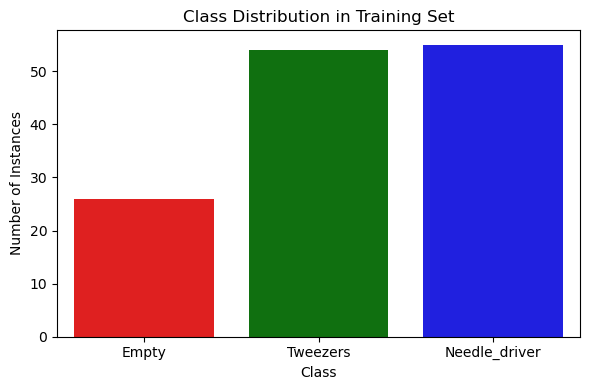

In [11]:
label_stat_df = pd.DataFrame(list(label_stat.items()), columns=["Class", "Count"])
label_stat_df["Class Name"] = label_stat_df["Class"].map(categories)

sizes_df = pd.DataFrame(sizes, columns=["Width", "Height"])
plt.figure(figsize=(6, 4))
sns.barplot(x="Class Name", y="Count", data=label_stat_df,hue="Class Name",
            palette=["red", "green", "blue"])
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Instances")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


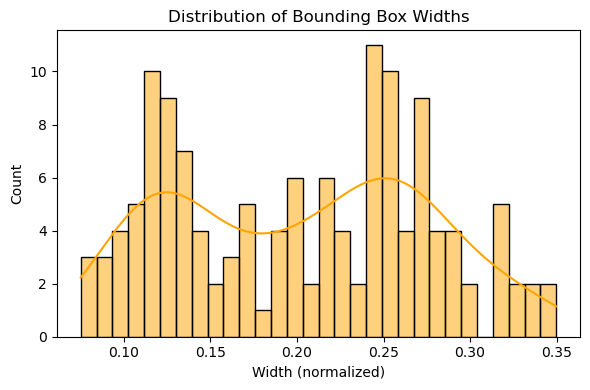

In [12]:
plt.figure(figsize=(6, 4))
sns.histplot(sizes_df["Width"], kde=True, color="orange", bins=30)
plt.title("Distribution of Bounding Box Widths")
plt.xlabel("Width (normalized)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

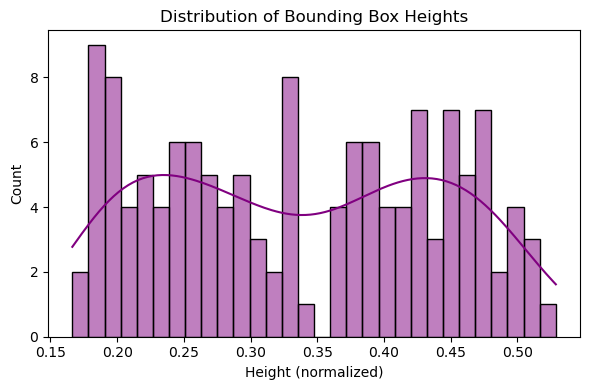

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(sizes_df["Height"], kde=True, color="purple", bins=30)
plt.title("Distribution of Bounding Box Heights")
plt.xlabel("Height (normalized)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

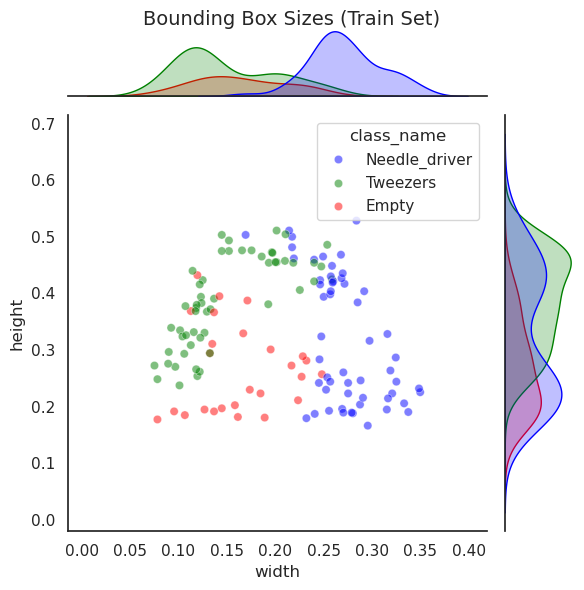

In [14]:
labels_per_box = []
for file in glob.glob(os.path.join(labels_train_dir, '*.txt')):
    with open(file) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            label = int(float(parts[0]))
            labels_per_box.append(label)

categories = {0: "Empty", 1: "Tweezers", 2: "Needle_driver"}
df = pd.DataFrame(sizes, columns=['width', 'height'])
df['label'] = labels_per_box
df['class_name'] = df['label'].map(categories)
sns.set(style="white")
g = sns.jointplot(
    data=df,
    x="width",
    y="height",
    hue="class_name",
    palette={"Empty": "red", "Tweezers": "green", "Needle_driver": "blue"},
    alpha=0.5
)
g.fig.suptitle("Bounding Box Sizes (Train Set)", fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)  # for title spacing
plt.show()


## Exploring images with YOLO boxes

In [15]:
image_path = imgs_train_dir + "06e0aac8-output_0037.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(2160, 3840, 3)

We will have to reshape it in training process as this is too large to process efectievely

In [16]:
def draw_yolo_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape

    boxes = []
    # Loading the boxes from txt file
    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            boxes.append((int(class_id), x_center, y_center, box_w, box_h))
    # each line represents a label, coordinates of the center: x, y , width and height        
    for class_id, x_center, y_center, box_w, box_h in boxes:
        x_center *= w
        y_center *= h
        box_w *= w
        box_h *= h

        x1 = int(x_center - box_w / 2)
        y1 = int(y_center - box_h / 2)
        x2 = int(x_center + box_w / 2)
        y2 = int(y_center + box_h / 2)

        color = colors[class_id] 
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = categories[class_id]
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [17]:
with open(labels_train_dir+"dc469e1a-frame_0895.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())

2 0.47444581280788173 0.7493158182813354 0.2789408866995074 0.18938149972632728
0 0.5132389162561576 0.6081007115489874 0.166871921182266 0.3295019157088122


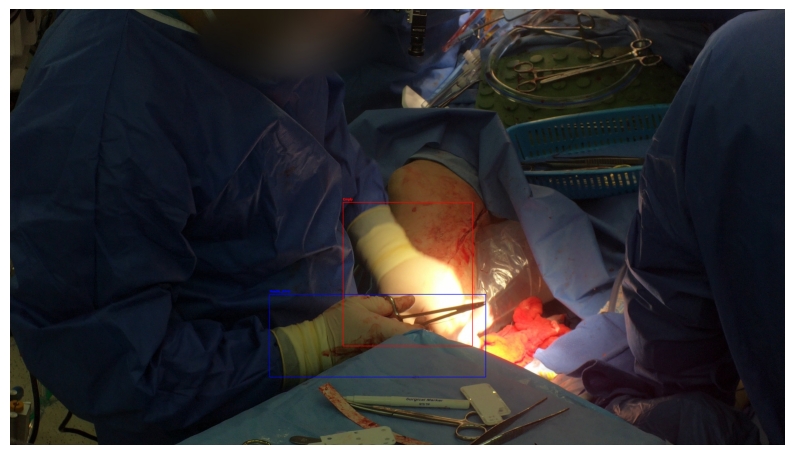

In [18]:
draw_yolo_boxes(imgs_train_dir+"dc469e1a-frame_0895.jpg", labels_train_dir+"dc469e1a-frame_0895.txt")

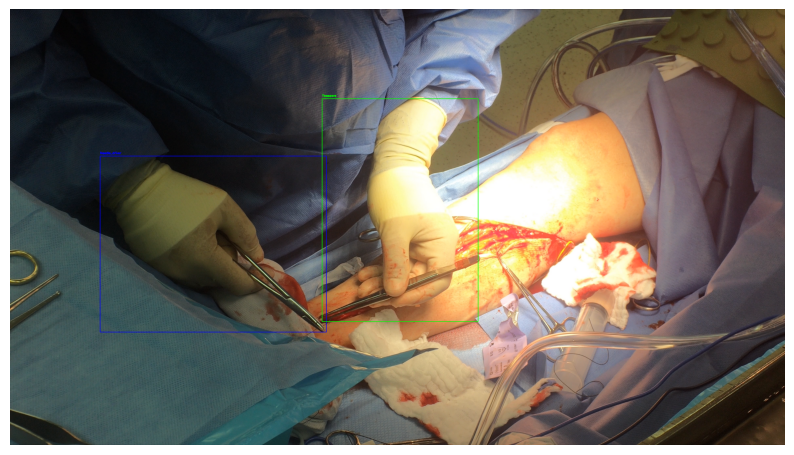

In [19]:
image_path = imgs_train_dir + "06e0aac8-output_0037.png"
label_path = labels_train_dir + "06e0aac8-output_0037.txt"

draw_yolo_boxes(image_path, label_path)

## Exploring videos

In [20]:
def show_video_sample(video_path, step=100):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_idx > 300:  # limit for speed
            break
        if frame_idx % step == 0:
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_idx}")
            plt.axis('off')
            plt.show()
        frame_idx += 1
    cap.release()

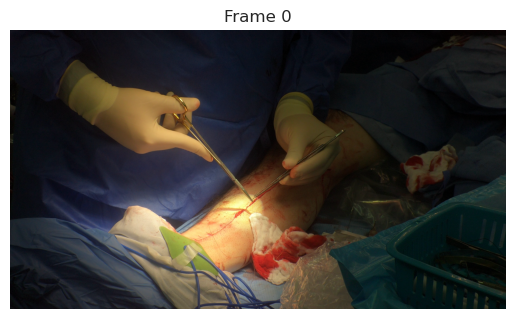

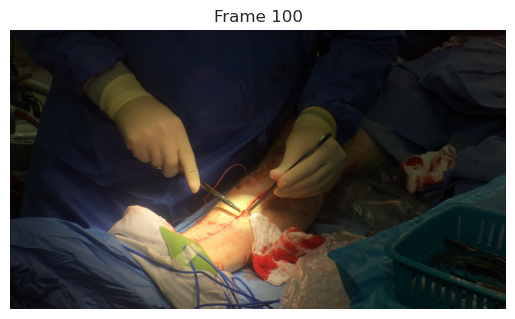

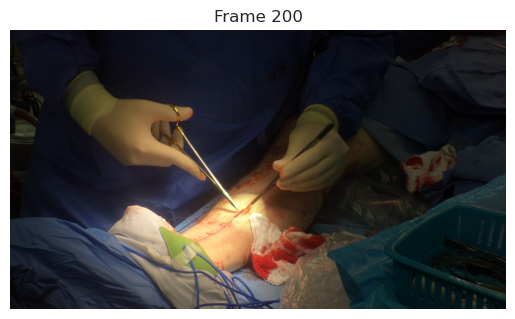

In [21]:
show_video_sample(ood_videos_dir + "surg_1.mp4")

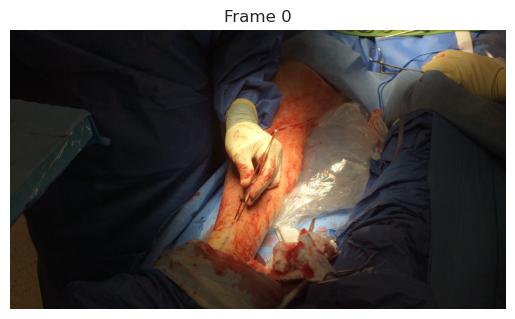

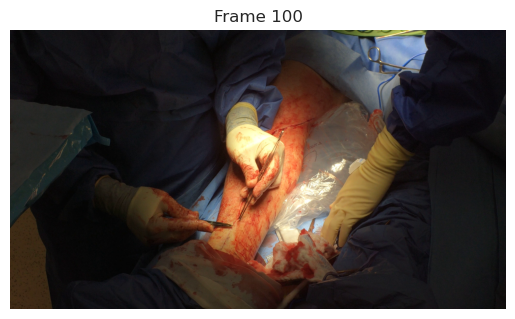

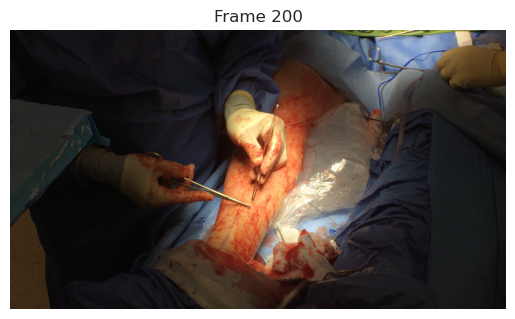

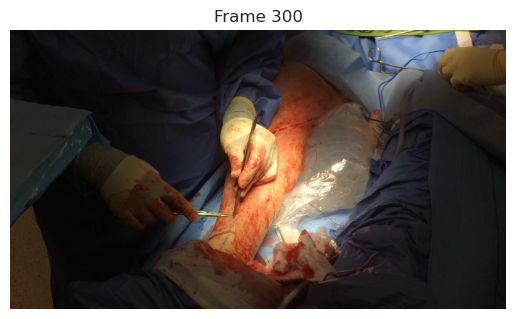

In [22]:
show_video_sample(id_videos_dir + "20_2_24_1.mp4")

# Base model (YOLOv9 without augmentations)

Here we used basic augmentations that are built in. 

This includes: 
- Random scale
- Random brightness/contrast
- Horizontal Flip

It dosnt't include another augmentations that can be helpful in this domain.

In [23]:
# %pip uninstall torch torchvision torchaudio -y
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [24]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla V100-PCIE-16GB


Very small and lightweight model

In [25]:
model = YOLO('yolov9c.pt') # tried c (for compact)

model.train(
    data = 'surgical.yaml',  
    epochs = 100, 
    imgsz = 640,
    batch = 16,              
    name = 'base_model1',
    workers = 8,
    patience = 20 # stopping early of no improvement is made in 10 epochs tried and failed:(
    )

model.save(trained_model_dir + "base_model1.pt")

Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=surgical.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base_model1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrai

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

train: Scanning /datashare/HW1/labeled_image_data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:02<00:00, 26.48it/s]

WARNING ⚠️ train: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.4±4.6 ms, read: 21.6±17.5 MB/s, size: 3348.1 KB)


val: Scanning /datashare/HW1/labeled_image_data/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 16.18it/s]

WARNING ⚠️ val: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


Plotting labels to runs/detect/base_model1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)


2025/06/01 18:10:54 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.


MLflow: logging run_id(6946950769da41aabc6115ad7b52af8b) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/base_model1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.96G      1.596      4.198      1.777         56        640: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         10         22    0.00232        0.3    0.00934     0.0016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        10G       1.65      4.211      1.852         64        640: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         10         22       0.72        0.5      0.697      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.2G      1.076      2.044      1.339         48        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         10         22      0.675       0.58      0.631      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.2G     0.9933      1.499       1.27         55        640: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         10         22      0.491      0.533      0.552      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      10.2G     0.9087       1.11      1.124         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         10         22      0.606      0.821      0.596      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      10.2G     0.9037      1.035      1.119         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         10         22      0.757      0.733      0.773      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.2G     0.8616      1.038      1.125         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         10         22      0.546      0.759      0.791      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.2G     0.9715      1.049      1.233         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         10         22      0.771      0.433       0.58      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.2G     0.9447     0.9442      1.141         63        640: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]

                   all         10         22      0.377      0.567      0.442      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.2G     0.8658     0.9295      1.192         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]

                   all         10         22      0.817      0.637      0.585      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.2G     0.8653     0.7864      1.114         79        640: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]

                   all         10         22      0.666      0.833      0.837      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.2G     0.8831     0.8843        1.1         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         10         22     0.0358      0.607     0.0382     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      10.2G     0.9364     0.9028      1.149         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]

                   all         10         22      0.236      0.733      0.262      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.2G      0.866     0.8607      1.123         47        640: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]

                   all         10         22      0.228      0.733      0.272       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.2G     0.8644     0.7909      1.108         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]

                   all         10         22      0.481      0.767      0.516      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.2G     0.8553     0.8016      1.175         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]

                   all         10         22       0.49      0.733      0.515      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.2G     0.8514      0.709      1.057         60        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]

                   all         10         22      0.403      0.867      0.675      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.2G     0.8188     0.6968      1.084         74        640: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

                   all         10         22      0.331      0.778      0.474      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.2G     0.9376     0.7454      1.149         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]

                   all         10         22      0.313      0.702      0.468      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.2G     0.9069     0.7129       1.18         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         10         22       0.22      0.854      0.409      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.2G     0.9258     0.7448      1.135         65        640: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         10         22      0.405      0.733      0.439      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.2G     0.8715     0.6858      1.126         57        640: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]

                   all         10         22       0.38      0.567      0.524      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.2G     0.9175     0.6783      1.115         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         10         22      0.488        0.7      0.707      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.2G     0.8808     0.6468       1.06         71        640: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]

                   all         10         22      0.543        0.8      0.622      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.2G     0.8799     0.7313       1.14         47        640: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]

                   all         10         22      0.778      0.418      0.474      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.2G     0.8086     0.7085      1.073         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

                   all         10         22      0.721      0.522      0.563      0.405
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 0.025 hours.
Optimizer stripped from runs/detect/base_model1/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/base_model1/weights/best.pt, 51.6MB

Validating runs/detect/base_model1/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9c summary (fused): 156 layers, 25,321,561 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


                   all         10         22      0.757      0.733      0.773      0.628
                 Empty          2          2       0.38        0.5       0.62      0.471
              Tweezers          9         10      0.996        0.9      0.896      0.746
         Needle_driver          9         10      0.896        0.8      0.803      0.666
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/base_model1
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


Small model, perfect for Real-time predictions

In [26]:
model = YOLO('yolov9s.pt')

model.train(
    data = 'surgical.yaml',  
    epochs = 50, 
    imgsz = 640,
    batch = 16,              
    name = 'base_model2',
    workers = 8,
    )

model.save(trained_model_dir + "base_model2.pt")

Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=surgical.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /datashare/HW1/labeled_image_data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:02<00:00, 27.10it/s]

WARNING ⚠️ train: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 4.8±7.4 ms, read: 39.0±18.5 MB/s, size: 3348.1 KB)


val: Scanning /datashare/HW1/labeled_image_data/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 22.18it/s]

WARNING ⚠️ val: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


Plotting labels to runs/detect/base_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
MLflow: logging run_id(7a34a61eda244b4ea5e49549bc98e9d5) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/base_model2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       5.3G      1.853      4.493       1.99         56        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         10         22    0.00421        0.5    0.00468    0.00188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.33G      1.804      4.202      1.938         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         10         22       0.45      0.133        0.2      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.35G       1.41      2.543      1.568         48        640: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         10         22      0.401      0.433      0.494      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.35G      1.218      1.965      1.455         55        640: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         10         22      0.838      0.463      0.563      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.37G     0.9914      1.357      1.269         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         10         22      0.818      0.873      0.902      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.38G      1.012       1.28      1.242         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         10         22      0.594      0.707       0.72      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.38G     0.9503      1.028      1.248         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

                   all         10         22      0.701      0.896      0.792      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.38G     0.9165      1.046       1.26         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         10         22      0.609      0.733      0.649      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.38G     0.8387     0.9219      1.155         63        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         10         22        0.6      0.767      0.665      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.38G     0.8232     0.9072       1.18         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all         10         22      0.733      0.708       0.63      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.38G     0.8156     0.7827      1.084         79        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         10         22      0.736        0.7       0.73      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.38G      0.825     0.8003      1.114         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         10         22        0.9      0.732      0.724      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.38G     0.8754     0.8657      1.159         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         10         22      0.899      0.692      0.747      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.38G      0.813     0.7618      1.106         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         10         22      0.665      0.733      0.658      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.38G     0.8421     0.7389      1.095         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         10         22      0.591      0.722      0.663      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.38G     0.8503     0.7952      1.167         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]

                   all         10         22      0.922        0.7      0.774      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.38G     0.7813     0.6561      1.052         60        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         10         22      0.812      0.858      0.835      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.38G     0.8219     0.6759      1.091         74        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         10         22      0.709      0.884      0.738      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.38G     0.8045     0.6317      1.084         61        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         10         22      0.763      0.884      0.799      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.38G     0.7745     0.6396       1.08         53        640: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         10         22       0.86      0.894      0.788      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.38G     0.7761     0.6299      1.106         65        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         10         22      0.843      0.889        0.8      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.38G     0.7607     0.6078      1.075         57        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]

                   all         10         22       0.81      0.888      0.817      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.38G     0.7974     0.6229      1.059         61        640: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

                   all         10         22      0.911      0.736      0.848      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.38G     0.7574     0.6008      1.053         71        640: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         10         22      0.944      0.739      0.816      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.38G     0.7893     0.6288      1.087         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all         10         22      0.724      0.733       0.79      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.38G      0.744     0.5298      1.046         58        640: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all         10         22      0.707      0.889      0.797      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.38G      0.731     0.5914      1.046         45        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]

                   all         10         22       0.81      0.863      0.825      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.38G      0.791     0.5424      1.059         57        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

                   all         10         22      0.871       0.91      0.827      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.38G     0.7078     0.5255      1.043         60        640: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         10         22      0.934      0.719       0.85      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.38G     0.7181      0.499      1.014         70        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         22      0.898      0.684      0.813      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.38G     0.6368     0.4988     0.9835         65        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         10         22      0.807      0.917      0.853       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.38G     0.7255     0.5093      1.074         72        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

                   all         10         22      0.983      0.914      0.936      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.38G     0.6807     0.4922      1.035         56        640: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

                   all         10         22      0.985      0.919      0.935      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.38G     0.7101     0.4745       1.02         67        640: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]

                   all         10         22      0.985      0.933      0.934      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.38G     0.6902     0.4677      1.013         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         10         22      0.984      0.929      0.934      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.38G     0.6555     0.4724     0.9982         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         10         22      0.983      0.925      0.934      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.38G     0.7261     0.5378      1.069         46        640: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         10         22      0.982      0.929      0.935      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.38G     0.7047     0.4963      1.027         60        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]

                   all         10         22      0.981      0.927      0.936      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.38G     0.6282     0.4183     0.9972         68        640: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         10         22       0.98      0.927      0.938      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.38G      0.642      0.427     0.9907         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

                   all         10         22       0.98      0.933      0.939       0.71


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.38G     0.5144     0.3977     0.9457         27        640: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


                   all         10         22       0.97      0.929       0.94      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.38G     0.5222     0.3618     0.9698         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         10         22      0.963      0.919      0.939      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.38G     0.5104     0.3479     0.9426         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

                   all         10         22      0.825      0.933      0.884      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.38G     0.5297     0.3793     0.9552         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         10         22      0.844      0.933      0.885      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.38G      0.496     0.3379     0.9109         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         10         22      0.857      0.932      0.885      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.38G      0.494     0.3269     0.9469         30        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

                   all         10         22      0.978      0.912      0.942      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.38G     0.4668     0.3031     0.8945         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

                   all         10         22      0.981      0.905      0.943      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.38G     0.4755       0.32     0.9287         28        640: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all         10         22      0.985      0.901      0.943      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.38G     0.4464      0.287     0.9231         29        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]

                   all         10         22      0.987      0.904      0.943      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.38G     0.4331     0.2903     0.8842         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

                   all         10         22      0.989      0.909      0.943       0.75



50 epochs completed in 0.035 hours.
Optimizer stripped from runs/detect/base_model2/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/base_model2/weights/best.pt, 15.2MB

Validating runs/detect/base_model2/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


                   all         10         22      0.987      0.904      0.943      0.766
                 Empty          2          2          1      0.972      0.995      0.723
              Tweezers          9         10      0.961        0.9      0.917      0.791
         Needle_driver          9         10          1       0.84      0.916      0.785
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/base_model2
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


Slightly larger model, which enhances the overall accuracy of the predictions, but a litttle bit more heavy to work with

In [27]:
model = YOLO('yolov9e.pt')

model.train(
    data = 'surgical.yaml',  
    epochs = 50, # tried 100
    imgsz = 640,
    batch = 8,    # tried 16 and 32            
    name = 'base_model3',
    workers = 8,
    )

model.save(trained_model_dir + "base_model3.pt")

Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=surgical.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9e.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base_model3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /datashare/HW1/labeled_image_data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:02<00:00, 25.91it/s]

WARNING ⚠️ train: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.3 ms, read: 36.8±15.4 MB/s, size: 3348.1 KB)


val: Scanning /datashare/HW1/labeled_image_data/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 25.78it/s]

WARNING ⚠️ val: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


Plotting labels to runs/detect/base_model3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
MLflow: logging run_id(c82b85a11a534925a3e573caed5bc97e) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/base_model3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.9G       1.78      3.741      2.032         22        640: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10         22      0.199      0.567      0.304      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.2G      1.056      2.494      1.372         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         10         22      0.239        0.4      0.269      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.2G     0.9674      2.108      1.259         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         10         22      0.327      0.833      0.287      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.1G      1.015      1.679      1.245         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         10         22      0.143      0.333      0.105     0.0776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.3G      1.023      1.444      1.202         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         10         22      0.194      0.733      0.274      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.2G      1.033      1.418      1.239         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         10         22      0.671     0.0333   0.000658   0.000216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.1G      1.087       1.45      1.308         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         10         22   0.000941      0.267   0.000911   0.000317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50        10G      1.025      1.273      1.334         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


                   all         10         22   0.000317     0.0667   0.000205   0.000132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.1G      1.148       1.34      1.363         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         10         22   0.000112     0.0333   8.35e-05   3.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.2G      1.091      1.331      1.314         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


                   all         10         22          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        10G      1.124      1.224        1.3         24        640: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        10G      1.133      1.269       1.28         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50        10G      1.097      1.274      1.222         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.2G      1.112      1.781      1.338         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         10         22      0.667     0.0333   8.78e-05   8.78e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.2G      1.068      1.519      1.273         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        10G      1.055      1.109      1.251         23        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         10         22   0.000912        0.1   0.000673   0.000238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50        10G     0.9676     0.9317      1.175         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50        10G      1.047      1.064      1.228         25        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.2G      1.028     0.9674       1.23         24        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


                   all         10         22   0.000297     0.0667   0.000331   0.000103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.2G       1.09      1.003      1.297         32        640: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         10         22    0.00111        0.1   0.000792   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.2G      1.122     0.9332      1.329         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         10         22   0.000554     0.0333   0.000363   6.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        10G      1.093     0.9983      1.291         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         10         22   0.000555        0.1   0.000315     0.0001



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        10G     0.9727     0.9062      1.204         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         10         22   0.000198     0.0333   0.000109   4.37e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        10G     0.8815     0.8734      1.137         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.2G     0.9029     0.8463       1.18         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


                   all         10         22    0.00104     0.0667   0.000483   6.88e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        10G     0.9168     0.7918      1.163         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.2G     0.8871       0.78      1.163         15        640: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        10G     0.9804     0.8247        1.2         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        10G     0.9674     0.8387      1.195         24        640: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         10         22     0.0265     0.0667     0.0337     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        10G     0.9346     0.8304      1.173         27        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


                   all         10         22      0.251        0.3       0.19        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.2G     0.8393     0.6958      1.119         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         10         22      0.713      0.267      0.284      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50        10G     0.8042     0.6617      1.088         25        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         10         22      0.731      0.421      0.428       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.2G      0.846     0.6736      1.137         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         10         22      0.319      0.582       0.41      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        10G     0.8522     0.6459      1.102         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         10         22      0.606      0.788      0.713      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        10G     0.7818     0.6301       1.07         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         10         22      0.633      0.867      0.812      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.2G     0.8123     0.6113      1.075         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         10         22      0.811      0.807      0.834      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.2G     0.8286     0.6554      1.159         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         10         22       0.85      0.851      0.922      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.97G     0.8248     0.6718      1.105         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         10         22      0.846      0.881      0.927      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.2G     0.7538     0.5881      1.068         26        640: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


                   all         10         22      0.857       0.88       0.93      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50        10G     0.7787     0.5758      1.106         16        640: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         10         22      0.842      0.827      0.841      0.653


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.2G     0.6144     0.4975     0.9795         10        640: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         10         22      0.817      0.857      0.873      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        10G     0.6119     0.4759      1.013         12        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


                   all         10         22      0.951      0.804       0.92       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.2G     0.5806     0.4431     0.9643         10        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


                   all         10         22      0.972      0.817      0.907      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        10G     0.6093     0.4838      1.027         10        640: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         10         22      0.974      0.827      0.907      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50        10G     0.6234     0.5145      1.026         13        640: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


                   all         10         22      0.944      0.822      0.907      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.2G     0.5745     0.4049       1.01         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


                   all         10         22      0.931      0.793      0.906      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50        10G     0.5535     0.3967      0.956         13        640: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         10         22      0.788        0.9      0.907      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        10G     0.5455     0.3826     0.9632         12        640: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         10         22      0.911      0.825      0.907      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.2G     0.5303     0.3773     0.9648         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         10         22       0.92      0.848      0.925      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.2G      0.512      0.358     0.9394         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         10         22      0.941      0.858      0.931      0.724



50 epochs completed in 0.134 hours.
Optimizer stripped from runs/detect/base_model3/weights/last.pt, 117.2MB
Optimizer stripped from runs/detect/base_model3/weights/best.pt, 117.2MB

Validating runs/detect/base_model3/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9e summary (fused): 279 layers, 57,378,713 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


                   all         10         22      0.857       0.88      0.931      0.725
                 Empty          2          2      0.579          1      0.995      0.649
              Tweezers          9         10          1       0.84      0.904      0.794
         Needle_driver          9         10      0.992        0.8      0.892      0.733
Speed: 0.1ms preprocess, 6.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/base_model3
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


# YOLOv9 Custom Augmentations

Implementing another augmentations that can be helpful

In [28]:
os.makedirs("data", exist_ok=True)

In [29]:
# output directris for additional augmented images
out_img_dir = "data/augmented/images/train/"
out_lbl_dir = "data/augmented/labels/train/"
os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_lbl_dir, exist_ok=True)

# Custom augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Rotate(limit=15, p=0.3),
    A.MotionBlur(p=0.2),
    A.CLAHE(p=0.1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for filename in os.listdir(imgs_train_dir):
    name, ext = os.path.splitext(filename)
    img_path = os.path.join(imgs_train_dir, filename)
    label_path = os.path.join(labels_train_dir, name + ".txt")

    image = cv2.imread(img_path)
    height, width = image.shape[:2]

    bboxes, class_labels = [], []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                label, x, y, w, h = map(float, line.strip().split())
                bboxes.append([x, y, w, h])
                class_labels.append(int(label))

    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

    new_name = name + "_aug"
    new_img_path = os.path.join(out_img_dir, new_name + ".jpg")
    cv2.imwrite(new_img_path, transformed["image"])
    # saving the new picture 
    new_label_path = os.path.join(out_lbl_dir, new_name + ".txt")
    with open(new_label_path, "w") as f:
        for box, label in zip(transformed["bboxes"], transformed["class_labels"]):
            x, y, w, h = box
            f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

In [30]:
original_img_dir = "/datashare/HW1/labeled_image_data/images/val/"
original_lbl_dir = "/datashare/HW1/labeled_image_data/labels/val/"
local_img_dir = "./data/augmented/images/val"
local_lbl_dir = "./data/augmented/labels/val"
os.makedirs(local_img_dir, exist_ok=True)
os.makedirs(local_lbl_dir, exist_ok=True)

for f in os.listdir(original_img_dir):
    base = os.path.splitext(f)[0]
    shutil.copy2(os.path.join(original_img_dir, f), os.path.join(local_img_dir, f))
    shutil.copy2(os.path.join(original_lbl_dir, base + ".txt"), os.path.join(local_lbl_dir, base + ".txt"))

In [31]:
model = YOLO('yolov9s.pt')

model.train(
    data='custom_aug.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='custom_augmentations',
    workers=8,
    auto_augment = False
)
model.save(trained_model_dir + "custom_augmentations.pt")

Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=False, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom_aug.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=custom_augmentations, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

train: Scanning /home/student/HW1/data/augmented/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 1702.12it/s]

train: New cache created: /home/student/HW1/data/augmented/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 891.9±53.9 MB/s, size: 3348.1 KB)


val: Scanning /home/student/HW1/data/augmented/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 31.87it/s]

val: New cache created: /home/student/HW1/data/augmented/labels/val.cache


Plotting labels to runs/detect/custom_augmentations/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
MLflow: logging run_id(8c52775b5ae64cd39a7b10314c2ca65e) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/custom_augmentations
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.46G      2.158       4.49      2.227         59        640: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


                   all         10         22    0.00391      0.467    0.00449     0.0018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.52G      1.938      4.278        2.1         66        640: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         10         22     0.0807        0.2     0.0912     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.54G      1.568      2.915       1.73         48        640: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         10         22      0.515      0.265      0.389      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.54G      1.436      2.279      1.701         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


                   all         10         22      0.849        0.4      0.632      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.56G       1.22      1.579      1.461         70        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         10         22      0.575      0.797      0.668      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.57G       1.25      1.598       1.49         54        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         10         22      0.743        0.5      0.559       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.57G      1.167      1.314       1.41         62        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         10         22      0.948      0.533      0.586      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.57G      1.122      1.252      1.391         51        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         10         22      0.606        0.7      0.706      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.57G      1.104      1.169      1.333         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]

                   all         10         22      0.592      0.767      0.822      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.57G       1.02       1.05       1.34         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         10         22      0.889        0.7       0.78      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.57G      1.098     0.9838      1.334         82        640: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         10         22      0.592      0.767      0.829      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.57G      1.035     0.9348      1.287         54        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         10         22      0.774      0.635      0.842      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.57G      1.026     0.9412      1.276         44        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         10         22      0.911      0.809      0.881       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.57G      1.017     0.9128       1.26         49        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all         10         22      0.887      0.673      0.863      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.57G     0.9505     0.8065      1.207         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         10         22      0.786      0.763      0.846       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.57G     0.9322     0.8572      1.246         54        640: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


                   all         10         22       0.81      0.933      0.871      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.57G     0.9195     0.7497      1.136         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


                   all         10         22      0.822      0.924      0.874      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.57G     0.9807     0.7823      1.224         72        640: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

                   all         10         22      0.805        0.9      0.871      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.57G     0.9216     0.7619      1.206         63        640: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         10         22       0.82        0.9      0.843      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.57G     0.8916     0.6965      1.172         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         10         22      0.808      0.898      0.866      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.57G     0.8919     0.7061      1.196         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


                   all         10         22      0.771       0.88      0.831      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.57G     0.9848      0.811      1.239         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         10         22       0.82      0.931      0.846      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.57G     0.9281     0.6824      1.168         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


                   all         10         22      0.801      0.933      0.847      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.57G     0.9079     0.6392      1.133         69        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         10         22        0.8      0.767       0.83      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.57G     0.9238     0.6751      1.216         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         10         22      0.816      0.755      0.824      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.57G     0.8228     0.6489      1.143         58        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

                   all         10         22      0.947      0.879      0.932      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.57G     0.8992     0.6366      1.164         48        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         10         22      0.895      0.861      0.933       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.57G     0.9199     0.6387      1.188         57        640: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

                   all         10         22      0.993      0.863      0.933      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.57G      0.861     0.6352      1.156         59        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]

                   all         10         22      0.997       0.87      0.934      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.57G     0.8882     0.6176      1.111         71        640: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

                   all         10         22      0.979      0.933      0.932       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.57G     0.7899     0.5445      1.098         59        640: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         10         22      0.974      0.924      0.931      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.57G     0.8735     0.6062      1.141         72        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

                   all         10         22      0.919      0.918      0.931      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.57G     0.8459     0.5579      1.145         52        640: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]

                   all         10         22      0.899      0.928      0.931      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.57G     0.8314      0.566      1.105         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


                   all         10         22      0.981      0.931      0.931      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.57G     0.8169     0.5595      1.094         56        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

                   all         10         22      0.985      0.933      0.931      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.57G     0.7895     0.5314      1.089         63        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all         10         22      0.973      0.925      0.932      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.57G     0.8352     0.6308      1.147         46        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         10         22       0.99      0.909      0.932      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.57G     0.8464     0.5367      1.112         57        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         10         22      0.997      0.885      0.933      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.57G     0.7645     0.5011      1.094         70        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

                   all         10         22      0.974      0.901      0.934      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.57G     0.7167     0.4836      1.078         54        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]

                   all         10         22      0.954      0.902      0.934      0.812


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.57G     0.6535     0.4853      1.072         27        640: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


                   all         10         22      0.963      0.902      0.934      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.57G      0.611     0.4041       1.05         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         10         22      0.969      0.933      0.934      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.57G     0.6433     0.3989      1.026         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         10         22      0.966      0.933      0.936      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.57G     0.6675     0.4281      1.042         28        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         22      0.966      0.933      0.938      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.57G     0.5901     0.3788      1.011         25        640: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         10         22      0.979      0.919      0.938      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.57G     0.6248     0.3804      1.038         30        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         10         22       0.98      0.912       0.94       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.57G     0.5451      0.358       0.98         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         10         22      0.982      0.917       0.94      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.57G     0.5738     0.3661      1.018         28        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]

                   all         10         22      0.984      0.923      0.939      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.57G     0.5511     0.3337     0.9781         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         10         22      0.987      0.932       0.94      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.57G     0.5369      0.337     0.9571         26        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]

                   all         10         22      0.989      0.932       0.94      0.816



50 epochs completed in 0.033 hours.
Optimizer stripped from runs/detect/custom_augmentations/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/custom_augmentations/weights/best.pt, 15.2MB

Validating runs/detect/custom_augmentations/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


                   all         10         22      0.919      0.918      0.931      0.839
                 Empty          2          2      0.761          1      0.995      0.995
              Tweezers          9         10          1      0.854      0.901      0.782
         Needle_driver          9         10      0.995        0.9      0.898      0.741
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/custom_augmentations
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


# Final Model 
*Semi-Supervised with augmentations*

## In Distribution videos

In [32]:
save_dir = "data/pseudo/labels/train"  # Output labels
img_dir = "data/pseudo/images/train"   # Save matching frames

os.makedirs(save_dir, exist_ok=True)
os.makedirs(img_dir, exist_ok=True)

original_img_dir = "/datashare/HW1/labeled_image_data/images/val/"
original_lbl_dir = "/datashare/HW1/labeled_image_data/labels/val/"
local_img_dir = "./data/pseudo/images/val"
local_lbl_dir = "./data/pseudo/labels/val"
os.makedirs(local_img_dir, exist_ok=True)
os.makedirs(local_lbl_dir, exist_ok=True)

for f in os.listdir(original_img_dir):
    base = os.path.splitext(f)[0]
    shutil.copy2(os.path.join(original_img_dir, f), os.path.join(local_img_dir, f))
    shutil.copy2(os.path.join(original_lbl_dir, base + ".txt"), os.path.join(local_lbl_dir, base + ".txt"))

In [33]:
# model = YOLO("runs/detect/base_model2/weights/best.pt")  

# id_videos_name = ["20_2_24_1", "4_2_24_B_2"]
# # Read video 1
# for video in id_videos_name:
#     cap = cv2.VideoCapture(id_videos_dir + video + ".mp4")
#     frame_idx = 0

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Save image for later training
#         img_name = video + f"_frame{frame_idx:04d}.jpg"
#         img_path = os.path.join(img_dir, img_name)
#         cv2.imwrite(img_path, frame)

#         results = model.predict(source=frame, conf=0.3, verbose=False)
#         # Save predictions to txt
#         result = results[0]
#         boxes = result.boxes.xywh.cpu().numpy()
#         confs = result.boxes.conf.cpu().numpy()
#         classes = result.boxes.cls.cpu().numpy().astype(int)

#         label_path = os.path.join(save_dir, img_name.replace(".jpg", ".txt"))
#         with open(label_path, "w") as f:
#             for (x, y, w, h), conf, label in zip(boxes, confs, classes):
#                 f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
#         frame_idx += 1

#     cap.release()

In [34]:
model = YOLO("runs/detect/base_model2/weights/best.pt")  

id_videos_name = ["20_2_24_1", "4_2_24_B_2"]
# Read video 1
for video in id_videos_name:
    cap = cv2.VideoCapture(id_videos_dir + video + ".mp4")
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps) # to save 1 frame per second instead of every frame
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % interval == 0:
            # Save image for later training
            img_name = video + f"_frame{frame_idx:04d}.jpg"
            img_path = os.path.join(img_dir, img_name)
            cv2.imwrite(img_path, frame)

            # Run prediction and save pseudo-labels
            results = model.predict(source=frame, conf=0.5, verbose=False)
            result = results[0]
            boxes = result.boxes.xywh.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)

            label_path = os.path.join(save_dir, img_name.replace(".jpg", ".txt"))
            with open(label_path, "w") as f:
                for (x, y, w, h), conf, label in zip(boxes, confs, classes):
                    f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        frame_idx += 1

In [35]:
# # this code is probably unnecesarry because we didn't save the conf
# def filter_txt_file(path, min_conf=0.7):
#     lines = []
#     with open(path, "r") as f:
#         for line in f:
#             parts = line.strip().split()
#             if len(parts) == 6 and float(parts[5]) >= min_conf:
#                 lines.append(" ".join(parts[:5]))  # drop conf column
#     with open(path, "w") as f:
#         for l in lines:
#             f.write(l + "\n")

# # Apply to all .txt files
# for file in os.listdir(save_dir):
#     if file.endswith(".txt"):
#         filter_txt_file(os.path.join(save_dir, file), min_conf=0.7)


In [36]:
# model = YOLO("runs/detect/base_model2/weights/best.pt")

model.train(
    data='pseudo.yaml',
    epochs = 30,
    batch = 16,
    imgsz = 640,
    name = 'fine_tuned_with_pseudo',
    workers = 8,
    
    )
model.save(trained_model_dir + "fine_tuned_with_pseudo.pt")

# model = YOLO("runs/detect/base_model2/weights/last.pt")
# model.train(resume=True)

Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pseudo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/base_model2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fine_tuned_with_pseudo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

  8                  -1  1   1028864  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 256, 256, 128, 3]       
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPELAN         [256, 256, 128]               
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    628800  ultralytics.nn.modules.block.RepNCSPELAN4    [448, 192, 192, 96, 3]        
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    283008  ultralytics.nn.modules.block.RepNCSPELAN4    [320, 128, 128, 64, 3]        
 16                  -1  1    110784  ultralytics.nn.modules.block.AConv           [128,

train: Scanning /home/student/HW1/data/pseudo/labels/train... 374 images, 8 backgrounds, 366 corrupt: 100%|██████████| 374/374 [00:00<00:00, 1686.95it/s]

train: /home/student/HW1/data/pseudo/images/train/20_2_24_1_frame0000.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1889.4      1010.1      441.61      943.58]
train: /home/student/HW1/data/pseudo/images/train/20_2_24_1_frame0029.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1888.3        1017      456.91       928.3      1182.9      1266.3      1050.1      605.96]
train: /home/student/HW1/data/pseudo/images/train/20_2_24_1_frame0058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1899.7      1032.8      456.27      952.86      1202.1      1338.1      1003.7      607.59]
train: /home/student/HW1/data/pseudo/images/train/20_2_24_1_frame0087.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1897.4      1029.3      455.06      943.52      3018.9      956.74       978.4      772.35      1183.9      1407.9      1078.6       610.5]
train: /home

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 853.5±43.4 MB/s, size: 3361.1 KB)


val: Scanning /home/student/HW1/data/pseudo/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 28.26it/s]

val: New cache created: /home/student/HW1/data/pseudo/labels/val.cache


Plotting labels to runs/detect/fine_tuned_with_pseudo/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
MLflow: logging run_id(829d119e24a743efba272b87ec7512ce) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/fine_tuned_with_pseudo
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.37G          0       46.9          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         10         22    0.00148      0.233    0.00603   0.000648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.37G          0      46.78          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         10         22     0.0018        0.3      0.016     0.0032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.37G          0      46.92          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


                   all         10         22    0.00248        0.5      0.172     0.0223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.37G          0      47.19          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         10         22    0.00257      0.533      0.119     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.37G          0       47.3          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

                   all         10         22    0.00222        0.5      0.106     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.37G          0      47.24          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]

                   all         10         22     0.0025      0.533     0.0198    0.00318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.37G          0      46.99          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all         10         22    0.00158        0.3    0.00839    0.00107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.41G          0      45.94          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         10         22    0.00129      0.267     0.0082    0.00082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.41G          0       45.3          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]

                   all         10         22     0.0013      0.267    0.00246   0.000246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.41G          0      44.35          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]

                   all         10         22    0.00129      0.267    0.00477   0.000494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.41G          0      43.74          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

                   all         10         22    0.00062     0.0667   0.000386    5.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.41G          0      43.18          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         10         22   0.000616     0.0667   0.000383   5.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.41G          0      42.63          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]

                   all         10         22   0.000304     0.0333    0.00017   5.11e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.41G          0      42.18          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         10         22   0.000305     0.0333    0.00017   5.11e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.41G          0      41.56          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]

                   all         10         22   0.000931        0.1    0.00056   8.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.41G          0      41.14          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]

                   all         10         22    0.00092        0.1    0.00055   8.81e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.41G          0      40.98          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]

                   all         10         22   0.000921        0.1   0.000547   7.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.41G          0      40.51          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         10         22   0.000921        0.1   0.000547   7.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.43G          0      40.63          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

                   all         10         22    0.00091        0.1   0.000536   0.000104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.43G          0      40.33          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         22    0.00091        0.1   0.000536   0.000104


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.43G          0      40.48          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         10         22   0.000896        0.1   0.000537   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.43G          0      40.14          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         10         22   0.000896        0.1   0.000537   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.43G          0      40.04          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

                   all         10         22    0.00179        0.2    0.00215   0.000506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.43G          0      39.85          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         10         22    0.00179        0.2    0.00215   0.000506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.43G          0      39.88          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         10         22    0.00267        0.3     0.0105    0.00177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.43G          0      39.64          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all         10         22    0.00267        0.3     0.0105    0.00177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.43G          0      39.65          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


                   all         10         22    0.00262        0.3    0.00951    0.00158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.43G          0      39.53          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         10         22    0.00262        0.3    0.00951    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.43G          0      39.58          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]

                   all         10         22    0.00258        0.3    0.00358   0.000771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.43G          0       39.4          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         10         22    0.00258        0.3    0.00358   0.000771



30 epochs completed in 0.012 hours.
Optimizer stripped from runs/detect/fine_tuned_with_pseudo/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/fine_tuned_with_pseudo/weights/best.pt, 15.2MB

Validating runs/detect/fine_tuned_with_pseudo/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


                   all         10         22    0.00248        0.5      0.172     0.0223
                 Empty          2          2    0.00326          1      0.338     0.0429
              Tweezers          9         10    0.00209        0.3      0.178     0.0236
         Needle_driver          9         10    0.00211        0.2    0.00131   0.000195
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/fine_tuned_with_pseudo
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## Fine tuning with OOD videos 
Same steps as in previous stage but on ood

In [37]:
save_dir = "data/pseudo_ood/labels/train" 
img_dir = "data/pseudo_ood/images/train"  

os.makedirs(save_dir, exist_ok=True)
os.makedirs(img_dir, exist_ok=True)

original_img_dir = "/datashare/HW1/labeled_image_data/images/val/"
original_lbl_dir = "/datashare/HW1/labeled_image_data/labels/val/"
local_img_dir = "./data/pseudo_ood/images/val"
local_lbl_dir = "./data/pseudo_ood/labels/val"
os.makedirs(local_img_dir, exist_ok=True)
os.makedirs(local_lbl_dir, exist_ok=True)

for f in os.listdir(original_img_dir):
    base = os.path.splitext(f)[0]
    shutil.copy2(os.path.join(original_img_dir, f), os.path.join(local_img_dir, f))
    shutil.copy2(os.path.join(original_lbl_dir, base + ".txt"), os.path.join(local_lbl_dir, base + ".txt"))

In [38]:
model = YOLO("runs/detect/fine_tuned_with_pseudo/weights/best.pt")  

od_videos_name = ["4_2_24_A_1", "surg_1"]
# Read video 1
for video in od_videos_name:
    cap = cv2.VideoCapture(ood_videos_dir + video + ".mp4")
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps) # to save 1 frame per second instead of every frame
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % interval == 0:
            img_name = video + f"_frame{frame_idx:04d}.jpg"
            img_path = os.path.join(img_dir, img_name)
            cv2.imwrite(img_path, frame)

            # Run prediction and save pseudo-labels
            results = model.predict(source=frame, conf=0.3, verbose=False)
            result = results[0]
            boxes = result.boxes.xywh.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)

            label_path = os.path.join(save_dir, img_name.replace(".jpg", ".txt"))
            with open(label_path, "w") as f:
                for (x, y, w, h), conf, label in zip(boxes, confs, classes):
                    f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        frame_idx += 1

In [39]:
model.train(
    data='pseudo_ood.yaml',
    epochs = 30,
    batch = 18,
    imgsz = 640,
    name = 'fine_tuned_with_pseudo_ood',
    workers = 8,
    
    )
model.save(trained_model_dir + "fine_tuned_pseudo_ood.pt")

# model = YOLO("runs/detect/base_model2/weights/last.pt")
# model.train(resume=True)

Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=18, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pseudo_ood.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/fine_tuned_with_pseudo/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fine_tuned_with_pseudo_ood, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

 12                  -1  1    628800  ultralytics.nn.modules.block.RepNCSPELAN4    [448, 192, 192, 96, 3]        
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    283008  ultralytics.nn.modules.block.RepNCSPELAN4    [320, 128, 128, 64, 3]        
 16                  -1  1    110784  ultralytics.nn.modules.block.AConv           [128, 96]                     
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    598080  ultralytics.nn.modules.block.RepNCSPELAN4    [288, 192, 192, 96, 3]        
 19                  -1  1    221440  ultralytics.nn.modules.block.AConv           [192, 128]                    
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /home/student/HW1/data/pseudo_ood/labels/train... 198 images, 198 backgrounds, 0 corrupt: 100%|██████████| 198/198 [00:00<00:00, 2296.65it/s]

train: New cache created: /home/student/HW1/data/pseudo_ood/labels/train.cache
WARNING ⚠️ Labels are missing or empty in /home/student/HW1/data/pseudo_ood/labels/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 966.6±1110.1 MB/s, size: 5584.5 KB)


val: Scanning /home/student/HW1/data/pseudo_ood/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 28.57it/s]

val: New cache created: /home/student/HW1/data/pseudo_ood/labels/val.cache


Plotting labels to runs/detect/fine_tuned_with_pseudo_ood/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005625000000000001), 227 bias(decay=0.0)
MLflow: logging run_id(e17adb836f5a4c5c84baed217e9ee0fc) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/fine_tuned_with_pseudo_ood
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.69G          0      105.9          0          0        640: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         10         22    0.00247        0.4     0.0559    0.00943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.71G          0      90.16          0          0        640: 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


                   all         10         22    0.00167      0.167    0.00119    0.00016

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.71G          0      81.54          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         10         22    0.00115        0.1   0.000756   9.85e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.71G          0      74.15          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.71G          0      65.75          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.71G          0      58.61          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.71G          0      52.62          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.71G          0      47.31          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.71G          0      41.73          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.71G          0      37.49          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.71G          0      34.15          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.71G          0      30.89          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.71G          0      28.26          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.71G          0      25.86          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.71G          0       23.7          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.71G          0      21.72          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.71G          0      20.09          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.71G          0      18.63          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.71G          0      17.36          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.71G          0      16.18          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]

                   all         10         22          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.71G          0      15.23          0          0        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.71G          0      14.41          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.71G          0      13.74          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.71G          0      13.12          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.71G          0       12.6          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.71G          0      12.19          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.71G          0      11.84          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.71G          0      11.53          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.71G          0      11.33          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.71G          0      11.21          0          0        640: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]

                   all         10         22          0          0          0          0



30 epochs completed in 0.034 hours.
Optimizer stripped from runs/detect/fine_tuned_with_pseudo_ood/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/fine_tuned_with_pseudo_ood/weights/best.pt, 15.2MB

Validating runs/detect/fine_tuned_with_pseudo_ood/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


                   all         10         22    0.00247        0.4     0.0559    0.00942
                 Empty          2          2    0.00116        0.5   0.000922   0.000369
              Tweezers          9         10      0.004        0.5      0.165     0.0275
         Needle_driver          9         10    0.00225        0.2    0.00139   0.000414
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/fine_tuned_with_pseudo_ood
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
